<a href="https://colab.research.google.com/github/ShadmanRafi/DR-CRY/blob/main/DR_CRYnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

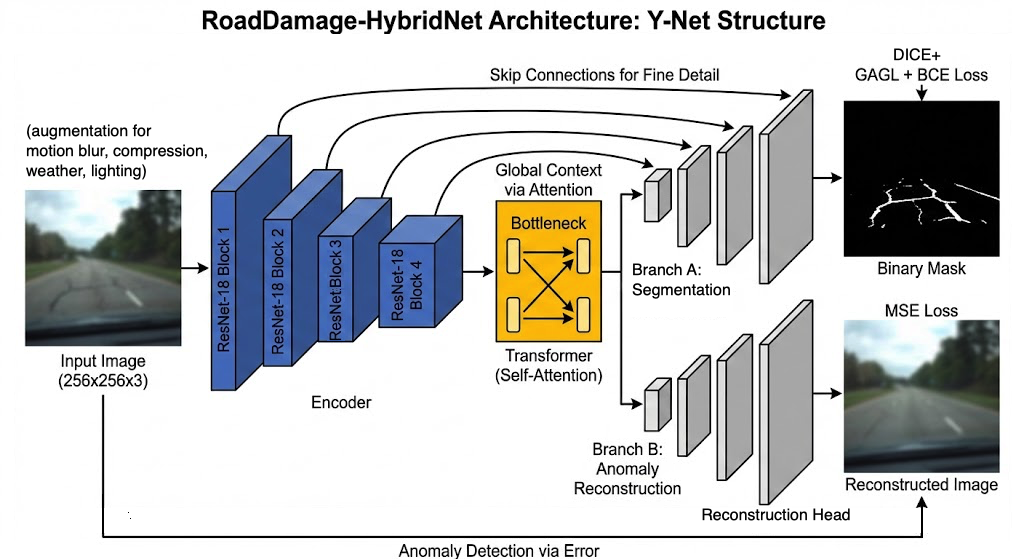

# Google Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# 1. Define Paths
# Note: Ensure your Drive is mounted before running this
zip_path = '/content/drive/MyDrive/CV Project/omnicrack30k.zip'
extract_to = '/content/omnicrack30k'

# 2. Extract the Zip File
if os.path.exists(zip_path):
    print(f"Found zip file at: {zip_path}")
    print(f"Extracting to: {extract_to} ...")

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print("Extraction successful!")
    except Exception as e:
        print(f"Error during extraction: {e}")
else:
    print(f"File not found: {zip_path}\nPlease check if Google Drive is mounted correctly.")

# 3. Visualize Directory Structure
def print_directory_tree(startpath, max_files=3):
    """
    Prints the directory tree structure.
    limits displayed files per folder to 'max_files' to keep output clean.
    """
    print(f"\n--- Directory Structure: {os.path.basename(startpath)} ---")

    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')

        subindent = ' ' * 4 * (level + 1)
        for f in files[:max_files]:
            print(f'{subindent}{f}')

        if len(files) > max_files:
            print(f'{subindent}... ({len(files) - max_files} more files)')

# Run the visualization if extraction worked
if os.path.exists(extract_to):
    print_directory_tree(extract_to)


Found zip file at: /content/drive/MyDrive/CV Project/omnicrack30k.zip
Extracting to: /content/omnicrack30k ...
Extraction successful!

--- Directory Structure: omnicrack30k ---
omnicrack30k/
    centerlines/
        test/
            LCW_279.png
            CRKWH100_1038.png
            Khanh11k_Rissbilder_for_Florian_9S6A2846_330_640_3250_2553.png
            ... (4579 more files)
        training/
            TopoDS_IMG_1250_93_2304_1792_mask.png
            LCW_279.png
            DeepCrack_11121.png
            ... (22155 more files)
        validation/
            CFD_086.png
            BCL_s403.png
            BCL_f194.png
            ... (3274 more files)
    images/
        test/
            LCW_279.png
            CRKWH100_1038.png
            Khanh11k_Rissbilder_for_Florian_9S6A2846_330_640_3250_2553.png
            ... (4579 more files)
        training/
            TopoDS_IMG_1250_93_2304_1792_mask.png
            LCW_279.png
            DeepCrack_11121.png
            ...

# Imports and Configuration

In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# Configuration
CONFIG = {
    "image_size": (512, 512),
    "batch_size": 8,
    "lr": 2e-4,
    "epochs": 30,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "num_workers": 2,
    "lambda_seg": 1.0,
    "lambda_recon": 0.5,
    "lambda_gagl": 0.5,
    "omnicrack_root": "/content/omnicrack30k"
}

# Data Augmentations for Robustness

In [ ]:
def get_transforms(phase="train"):
    if phase == "train":
        return A.Compose([
            A.Resize(height=CONFIG["image_size"][0], width=CONFIG["image_size"][1]),

            # Dashcam specific: Motion Blur & Compression
            A.OneOf([
                A.MotionBlur(p=0.5),
                A.ImageCompression(quality_range=(60, 100), p=0.5),
            ], p=0.5),

            # Weather/Lighting robustness
            A.OneOf([
                A.RandomBrightnessContrast(p=0.5),
                A.HueSaturationValue(p=0.5),
                # Simplified Fog to avoid version conflicts
                A.RandomFog(p=0.2),
            ], p=0.5),

            # Geometric Geometry
            A.HorizontalFlip(p=0.5),
            # Replaced ShiftScaleRotate with Affine to fix warning
            A.Affine(scale=(0.9, 1.1), rotate=(-15, 15), translate_percent=(0.1, 0.1), p=0.5),

            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(height=CONFIG["image_size"][0], width=CONFIG["image_size"][1]),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])

# Geometry Aware Guided Loss

In [ ]:
class GeometryAwareLoss(nn.Module):
    def __init__(self):
        super(GeometryAwareLoss, self).__init__()
        self.sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).view(1, 1, 3, 3)
        self.sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).view(1, 1, 3, 3)

    def forward(self, pred, target):
        if self.sobel_x.device != pred.device:
            self.sobel_x = self.sobel_x.to(pred.device)
            self.sobel_y = self.sobel_y.to(pred.device)

        edge_x = F.conv2d(target, self.sobel_x, padding=1)
        edge_y = F.conv2d(target, self.sobel_y, padding=1)
        edge_map = torch.sqrt(edge_x**2 + edge_y**2 + 1e-6)
        edge_map = (edge_map - edge_map.min()) / (edge_map.max() - edge_map.min() + 1e-6)

        weights = 1.0 + 4.0 * edge_map
        loss = F.binary_cross_entropy_with_logits(pred, target, weight=weights, reduction='mean')
        return loss

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)

        # Flatten
        pred = pred.view(-1)
        target = target.view(-1)

        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)

        return 1 - dice


class RoadDamageLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        self.gagl = GeometryAwareLoss()
        self.recon_loss = nn.MSELoss()

    def forward(self, seg_pred, seg_target, recon_pred, recon_target):
        l_bce = self.bce(seg_pred, seg_target)
        l_dice = self.dice(seg_pred, seg_target)
        l_seg = 0.5*l_bce + 0.5*l_dice
        l_gagl = self.gagl(seg_pred, seg_target)
        l_recon = self.recon_loss(recon_pred, recon_target)

        total_loss = (CONFIG["lambda_seg"] * l_seg +
                      CONFIG["lambda_gagl"] * l_gagl +
                      CONFIG["lambda_recon"] * l_recon)

        return total_loss, {"seg": l_seg.item(), "dice": l_dice.item(), "gagl": l_gagl.item(), "recon": l_recon.item()}

# Hybrid Model

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        B, C, H, W = x.shape
        x_flat = x.flatten(2).transpose(1, 2)
        attn_out, _ = self.attn(x_flat, x_flat, x_flat)
        x_flat = self.norm(x_flat + attn_out)
        x = x_flat.transpose(1, 2).reshape(B, C, H, W)
        return x

class RoadDamageHybridNet(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()

        # Encoder (ResNet18)
        # Using 'weights' parameter instead of 'pretrained' to fix warning
        base_model = models.resnet34(weights='DEFAULT')
        self.enc1 = nn.Sequential(base_model.conv1, base_model.bn1, base_model.relu, base_model.maxpool) # H/4
        self.enc2 = base_model.layer1 # H/4
        self.enc3 = base_model.layer2 # H/8
        self.enc4 = base_model.layer3 # H/16
        self.enc5 = base_model.layer4 # H/32

        # Bottleneck
        self.transformer = TransformerBlock(embed_dim=512, num_heads=8)

        # Segmentation Decoder
        self.up5 = self._up_block(512, 256)
        self.up4 = self._up_block(256, 128)
        self.up3 = self._up_block(128, 64)
        self.up2 = self._up_block(64, 32)
        self.final_conv = nn.Conv2d(32, n_classes, kernel_size=1)

        # Reconstruction Decoder
        self.recon_decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 2, 2), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 2, 2), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 2, 2), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 2, 2), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 2, 2), nn.Sigmoid()
        )

    def _up_block(self, in_c, out_c):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, 2, 2),
            nn.BatchNorm2d(out_c),
            nn.ReLU()
        )

    def forward(self, x):
        input_size = x.shape[-2:] # Get Input (H, W) dynamically

        # Encoder
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x4 = self.enc4(x3)
        x5 = self.enc5(x4)

        # Bottleneck
        x5_trans = self.transformer(x5)

        # Seg Head
        d5 = self.up5(x5_trans) + x4
        d4 = self.up4(d5) + x3
        d3 = self.up3(d4) + x2
        d2 = self.up2(d3)

        # FIX: Dynamically interpolate to input_size instead of hardcoded scale_factor
        d2 = F.interpolate(d2, size=input_size, mode='bilinear', align_corners=True)
        seg_out = self.final_conv(d2)

        # Recon Head
        recon_out = self.recon_decoder(x5_trans)
        if recon_out.shape[-2:] != input_size:
            recon_out = F.interpolate(recon_out, size=input_size, mode='bilinear', align_corners=True)

        return seg_out, recon_out

# Dataloader

In [ ]:
class RoadDataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None):
        self.transform = transform
        self.image_paths = []
        self.mask_paths = []

        img_dir = os.path.join(root_dir, split, "images")
        mask_dir = os.path.join(root_dir, split, "masks")

        if os.path.exists(img_dir):
            files = sorted(os.listdir(img_dir))
            for f in files:
                if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(img_dir, f))
                    self.mask_paths.append(os.path.join(mask_dir, f))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        _, mask = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].long()

        return image, mask.unsqueeze(0).float()

# Train

In [ ]:
def validate(model, loader, criterion, device):
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    num_batches = len(loader)

    with torch.no_grad(): # Disable gradients for validation
        for img, mask in loader:
            img = img.to(device)
            mask = mask.to(device)

            # Forward pass
            seg_pred, recon_pred = model(img)

            # Calculate Loss (Target for recon is the input image itself)
            loss, _ = criterion(seg_pred, mask, recon_pred, img)
            val_loss += loss.item()

            # Calculate IoU (Intersection over Union) for Segmentation
            # Apply sigmoid and threshold to get binary predictions
            preds = torch.sigmoid(seg_pred) > 0.5
            intersection = (preds & (mask > 0)).float().sum()
            union = (preds | (mask > 0)).float().sum()
            # Add small epsilon to avoid division by zero
            iou = (intersection + 1e-6) / (union + 1e-6)
            val_iou += iou.item()

    avg_loss = val_loss / num_batches
    avg_iou = val_iou / num_batches
    return avg_loss, avg_iou

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 204MB/s]


Starting Training...


Epoch 1/30: 100%|██████████| 237/237 [01:23<00:00,  2.84it/s, gagl=0.336, seg=0.527]


Epoch 1 Summary:
  Train Loss: 1.2934
  Val Loss:   0.8108
  Val IoU:    0.6624


Epoch 2/30: 100%|██████████| 237/237 [01:12<00:00,  3.27it/s, gagl=0.238, seg=0.462]


Epoch 2 Summary:
  Train Loss: 1.0155
  Val Loss:   0.6576
  Val IoU:    0.6648


Epoch 3/30: 100%|██████████| 237/237 [01:12<00:00,  3.28it/s, gagl=0.172, seg=0.389]


Epoch 3 Summary:
  Train Loss: 0.8868
  Val Loss:   0.5397
  Val IoU:    0.6818


Epoch 4/30: 100%|██████████| 237/237 [01:12<00:00,  3.27it/s, gagl=0.163, seg=0.424]


Epoch 4 Summary:
  Train Loss: 0.7918
  Val Loss:   0.4816
  Val IoU:    0.6669


Epoch 5/30: 100%|██████████| 237/237 [01:12<00:00,  3.27it/s, gagl=0.103, seg=0.311]


Epoch 5 Summary:
  Train Loss: 0.7263
  Val Loss:   0.4307
  Val IoU:    0.6773


Epoch 6/30: 100%|██████████| 237/237 [01:12<00:00,  3.27it/s, gagl=0.143, seg=0.315]


Epoch 6 Summary:
  Train Loss: 0.6837
  Val Loss:   0.3956
  Val IoU:    0.6915


Epoch 7/30: 100%|██████████| 237/237 [01:12<00:00,  3.27it/s, gagl=0.111, seg=0.273]


Epoch 7 Summary:
  Train Loss: 0.6524
  Val Loss:   0.3919
  Val IoU:    0.6765


Epoch 8/30: 100%|██████████| 237/237 [01:12<00:00,  3.27it/s, gagl=0.081, seg=0.172]


Epoch 8 Summary:
  Train Loss: 0.6345
  Val Loss:   0.3650
  Val IoU:    0.6884


Epoch 9/30: 100%|██████████| 237/237 [01:12<00:00,  3.27it/s, gagl=0.108, seg=0.224]


Epoch 9 Summary:
  Train Loss: 0.6145
  Val Loss:   0.3537
  Val IoU:    0.6974


Epoch 10/30: 100%|██████████| 237/237 [01:12<00:00,  3.27it/s, gagl=0.115, seg=0.181]


Epoch 10 Summary:
  Train Loss: 0.5998
  Val Loss:   0.3506
  Val IoU:    0.6921


Epoch 11/30: 100%|██████████| 237/237 [01:12<00:00,  3.27it/s, gagl=0.098, seg=0.170]


Epoch 11 Summary:
  Train Loss: 0.5906
  Val Loss:   0.3315
  Val IoU:    0.7058


Epoch 12/30: 100%|██████████| 237/237 [01:12<00:00,  3.27it/s, gagl=0.117, seg=0.187]


Epoch 12 Summary:
  Train Loss: 0.5783
  Val Loss:   0.3335
  Val IoU:    0.7002


Epoch 13/30: 100%|██████████| 237/237 [01:12<00:00,  3.27it/s, gagl=0.080, seg=0.181]


Epoch 13 Summary:
  Train Loss: 0.5714
  Val Loss:   0.3314
  Val IoU:    0.7010


Epoch 14/30: 100%|██████████| 237/237 [01:12<00:00,  3.27it/s, gagl=0.089, seg=0.162]


Epoch 14 Summary:
  Train Loss: 0.5676
  Val Loss:   0.3259
  Val IoU:    0.7006


Epoch 15/30: 100%|██████████| 237/237 [01:12<00:00,  3.27it/s, gagl=0.091, seg=0.141]


Epoch 15 Summary:
  Train Loss: 0.5589
  Val Loss:   0.3214
  Val IoU:    0.7034


Epoch 16/30: 100%|██████████| 237/237 [01:12<00:00,  3.27it/s, gagl=0.076, seg=0.139]


Epoch 16 Summary:
  Train Loss: 0.5528
  Val Loss:   0.3201
  Val IoU:    0.7052


Epoch 17/30: 100%|██████████| 237/237 [01:12<00:00,  3.27it/s, gagl=0.157, seg=0.213]


Epoch 17 Summary:
  Train Loss: 0.5488
  Val Loss:   0.3200
  Val IoU:    0.7015


Epoch 18/30: 100%|██████████| 237/237 [01:12<00:00,  3.27it/s, gagl=0.095, seg=0.152]


Epoch 18 Summary:
  Train Loss: 0.5440
  Val Loss:   0.3173
  Val IoU:    0.7016


Epoch 19/30: 100%|██████████| 237/237 [01:12<00:00,  3.27it/s, gagl=0.110, seg=0.167]


Epoch 19 Summary:
  Train Loss: 0.5379
  Val Loss:   0.3165
  Val IoU:    0.7019


Epoch 20/30: 100%|██████████| 237/237 [01:12<00:00,  3.27it/s, gagl=0.079, seg=0.119]


Epoch 20 Summary:
  Train Loss: 0.5342
  Val Loss:   0.3149
  Val IoU:    0.7012


Epoch 21/30: 100%|██████████| 237/237 [01:12<00:00,  3.27it/s, gagl=0.117, seg=0.150]


Epoch 21 Summary:
  Train Loss: 0.5284
  Val Loss:   0.3112
  Val IoU:    0.7066


Epoch 22/30: 100%|██████████| 237/237 [01:12<00:00,  3.27it/s, gagl=0.100, seg=0.158]


Epoch 22 Summary:
  Train Loss: 0.5277
  Val Loss:   0.3137
  Val IoU:    0.7061


Epoch 23/30: 100%|██████████| 237/237 [01:12<00:00,  3.27it/s, gagl=0.103, seg=0.149]


Epoch 23 Summary:
  Train Loss: 0.5242
  Val Loss:   0.3125
  Val IoU:    0.7029


Epoch 24/30: 100%|██████████| 237/237 [01:12<00:00,  3.26it/s, gagl=0.095, seg=0.161]


Epoch 24 Summary:
  Train Loss: 0.5206
  Val Loss:   0.3137
  Val IoU:    0.7019


Epoch 25/30: 100%|██████████| 237/237 [01:12<00:00,  3.26it/s, gagl=0.085, seg=0.137]


Epoch 25 Summary:
  Train Loss: 0.5175
  Val Loss:   0.3088
  Val IoU:    0.7059


Epoch 26/30: 100%|██████████| 237/237 [01:12<00:00,  3.26it/s, gagl=0.073, seg=0.118]


Epoch 26 Summary:
  Train Loss: 0.5169
  Val Loss:   0.3118
  Val IoU:    0.7030


Epoch 27/30: 100%|██████████| 237/237 [01:12<00:00,  3.27it/s, gagl=0.070, seg=0.121]


Epoch 27 Summary:
  Train Loss: 0.5159
  Val Loss:   0.3134
  Val IoU:    0.7011


Epoch 28/30: 100%|██████████| 237/237 [01:12<00:00,  3.26it/s, gagl=0.092, seg=0.150]


Epoch 28 Summary:
  Train Loss: 0.5127
  Val Loss:   0.3140
  Val IoU:    0.7010


Epoch 29/30: 100%|██████████| 237/237 [01:12<00:00,  3.26it/s, gagl=0.100, seg=0.155]


Epoch 29 Summary:
  Train Loss: 0.5142
  Val Loss:   0.3120
  Val IoU:    0.7017


Epoch 30/30: 100%|██████████| 237/237 [01:12<00:00,  3.27it/s, gagl=0.091, seg=0.137]


Epoch 30 Summary:
  Train Loss: 0.5151
  Val Loss:   0.3123
  Val IoU:    0.7027
Model saved.


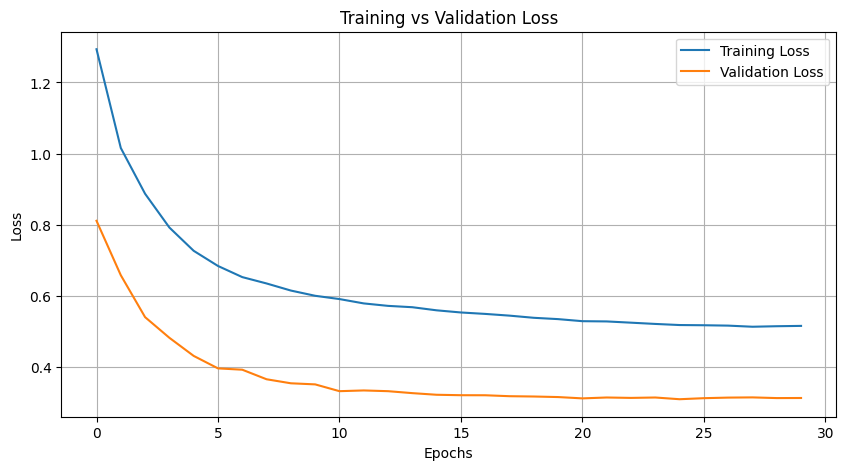

In [ ]:
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR


def train_model():
    DATA_PATH = '/content/drive/MyDrive/CV Project/last_submission/Crack500' # Check path!

    train_ds = RoadDataset(DATA_PATH, split="train", transform=get_transforms("train"))
    val_ds = RoadDataset(DATA_PATH, split="val", transform=get_transforms("val"))

    # Num workers=0 is safer for debugging in Colab to avoid shared memory errors
    train_loader = DataLoader(train_ds, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=2)

    model = RoadDamageHybridNet().to(CONFIG["device"])
    criterion = RoadDamageLoss().to(CONFIG["device"])
    optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG["lr"])

    scheduler = CosineAnnealingLR(optimizer, T_max=CONFIG["epochs"], eta_min=1e-6)

    train_history = []
    val_history = []

    print("Starting Training...")
    for epoch in range(CONFIG["epochs"]):
        model.train()
        train_loss = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']}")
        for img, mask in loop:
            img = img.to(CONFIG["device"])
            mask = mask.to(CONFIG["device"])

            # Forward
            seg_pred, recon_pred = model(img)

            # Calculate Loss (Note: recon target is the input image itself)
            loss, loss_dict = criterion(seg_pred, mask, recon_pred, img)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            loop.set_postfix(seg=f"{loss_dict['seg']:.3f}", gagl=f"{loss_dict['gagl']:.3f}")
        # Calculate average train losses
        avg_train_loss = train_loss / len(train_loader)
        scheduler.step()
        # Validation Step
        val_loss, val_iou = validate(model, val_loader, criterion, CONFIG["device"])
        # --- Store in History ---
        train_history.append(avg_train_loss)
        val_history.append(val_loss)
        # Log metrics
        print(f"Epoch {epoch+1} Summary:")
        print(f"  Train Loss: {train_loss / len(train_loader):.4f}")
        print(f"  Val Loss:   {val_loss:.4f}")
        print(f"  Val IoU:    {val_iou:.4f}")

    return model, train_history, val_history


def plot_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


# Execute
if __name__ == "__main__":
    if os.path.exists('/content/drive/MyDrive'):
        trained_model, train_loss_history, val_loss_history = train_model()
        torch.save(trained_model.state_dict(), "road_damage_hybridnet_latest.pth")
        print("Model saved.")
        plot_curves(train_loss_history, val_loss_history)
    else:
        print("Dataset path not found. Please verify Google Drive mounting.")

# Train on Omnicrack30k

## Dataloader

In [ ]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

# Configuration for reference (adjust as needed)

class OmniCrackDataset(Dataset):
    def __init__(self, root_dir, split="training", transform=None):
        self.transform = transform
        self.image_paths = []
        self.mask_paths = []

        split_map = {
            "train": "training", "training": "training",
            "val": "validation", "validation": "validation",
            "test": "test"
        }
        folder_name = split_map.get(split.lower(), split)

        img_dir = os.path.join(root_dir, "images", folder_name)
        mask_dir = os.path.join(root_dir, "annotations", folder_name)

        if os.path.exists(img_dir):
            valid_exts = ('.png', '.jpg', '.jpeg')
            files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(valid_exts)])

            for f in files:
                img_path = os.path.join(img_dir, f)
                mask_path = os.path.join(mask_dir, f)

                if os.path.exists(mask_path):
                    self.image_paths.append(img_path)
                    self.mask_paths.append(mask_path)
                else:
                    # Try .png fallback
                    name, _ = os.path.splitext(f)
                    mask_path_png = os.path.join(mask_dir, name + ".png")
                    if os.path.exists(mask_path_png):
                        self.image_paths.append(img_path)
                        self.mask_paths.append(mask_path_png)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        # Load Image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]

        # Load Mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # --- FIX: Ensure Mask shape matches Image shape ---
        if mask.shape[:2] != (h, w):
            mask = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)

        # Invert Mask: Background (255) -> 0, Crack (0) -> 1
        # OmniCrack masks are often: 255=Background, 0=Crack
        _, mask = cv2.threshold(mask, 127, 1.0, cv2.THRESH_BINARY_INV)

        if self.transform:
            try:
                augmented = self.transform(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask'].long()
            except ValueError as e:
                # Fallback if transform fails due to shape issues
                print(f"Skipping transform for {img_path} due to shape mismatch: {e}")
                # Use basic resize
                resizer = A.Compose([A.Resize(CONFIG["image_size"][0], CONFIG["image_size"][1]), ToTensorV2()])
                augmented = resizer(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask'].long()

        return image, mask.unsqueeze(0).float()

def get_omnicrack_transforms(phase="train", size=(448, 448)):
    """
    Returns transforms for training or validation/testing.
    Using the robust augmentation strategy from your proposal.
    """
    if phase == "train":
        return A.Compose([
            A.Resize(height=size[0], width=size[1]),

            # Robustness augmentations for Dashcam simulation
            A.OneOf([
                A.MotionBlur(p=0.5),
                A.ImageCompression(quality_lower=60, quality_upper=100, p=0.5),
                A.GaussNoise(p=0.5),
            ], p=0.5),

            # Lighting/Weather
            A.OneOf([
                A.RandomBrightnessContrast(p=0.5),
                A.HueSaturationValue(p=0.5),
                A.RandomFog(p=0.2),
            ], p=0.5),

            # Geometry
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=15, shift_limit=0.1, p=0.5),

            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])
    else:
        # Validation/Test: Only Resize and Normalize
        return A.Compose([
            A.Resize(height=size[0], width=size[1]),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])

def create_dataloaders(data_root, batch_size=8, num_workers=2, img_size=(448, 448)):
    """
    Helper function to instantiate all three dataloaders.
    """
    # 1. Create Datasets
    train_ds = OmniCrackDataset(
        data_root,
        split="training",
        transform=get_omnicrack_transforms("train", img_size)
    )

    val_ds = OmniCrackDataset(
        data_root,
        split="validation",
        transform=get_omnicrack_transforms("val", img_size)
    )

    test_ds = OmniCrackDataset(
        data_root,
        split="test",
        transform=get_omnicrack_transforms("test", img_size)
    )

    # 2. Create Loaders
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    print(f"DataLoaders created:")
    print(f"  Train: {len(train_ds)} images")
    print(f"  Val:   {len(val_ds)} images")
    print(f"  Test:  {len(test_ds)} images")

    return train_loader, val_loader, test_loader

## Train

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

def calculate_metrics(pred, target, threshold=0.5):
    pred = (torch.sigmoid(pred) > threshold).float()
    pred = pred.view(-1)
    target = target.view(-1)
    tp = (pred * target).sum().item()
    fp = (pred * (1 - target)).sum().item()
    fn = ((1 - pred) * target).sum().item()
    tn = ((1 - pred) * (1 - target)).sum().item()
    return tp, fp, fn, tn

def evaluate(model, loader, device):
    model.eval()
    total_tp, total_fp, total_fn, total_tn = 0, 0, 0, 0

    with torch.no_grad():
        for img, mask in tqdm(loader, desc="Evaluating"):
            img = img.to(device)
            mask = mask.to(device)
            seg_pred, _ = model(img)

            tp, fp, fn, tn = calculate_metrics(seg_pred, mask)
            total_tp += tp
            total_fp += fp
            total_fn += fn
            total_tn += tn

    eps = 1e-6
    precision = total_tp / (total_tp + total_fp + eps)
    recall = total_tp / (total_tp + total_fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    iou = total_tp / (total_tp + total_fp + total_fn + eps)
    accuracy = (total_tp + total_tn) / (total_tp + total_tn + total_fp + total_fn + eps)

    return {"iou": iou, "f1": f1, "precision": precision, "recall": recall, "accuracy": accuracy}


def train_omnicrack(epochs=30):
    # Dataloaders
    train_ds = OmniCrackDataset(CONFIG["omnicrack_root"], split="training", transform=get_transforms("train"))
    val_ds = OmniCrackDataset(CONFIG["omnicrack_root"], split="validation", transform=get_transforms("val"))

    train_loader = DataLoader(train_ds, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=CONFIG["num_workers"], pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"], pin_memory=True)

    # Model Setup
    model = RoadDamageHybridNet().to(CONFIG["device"])
    criterion = RoadDamageLoss().to(CONFIG["device"])
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG["lr"], weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

    best_iou = 0.0

    print("Starting Training...")
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for img, mask in loop:
            img = img.to(CONFIG["device"])
            mask = mask.to(CONFIG["device"])

            seg_pred, recon_pred = model(img)
            loss, loss_dict = criterion(seg_pred, mask, recon_pred, img)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            loop.set_postfix(loss=loss.item(), seg=loss_dict['seg'])

        scheduler.step()

        # Validation
        print(f"\nValidating Epoch {epoch+1}...")
        metrics = evaluate(model, val_loader, CONFIG["device"])
        print(f"Val IoU: {metrics['iou']:.4f}, F1: {metrics['f1']:.4f}, Recall: {metrics['recall']:.4f}")

        # Save Best
        if metrics['iou'] > best_iou:
            best_iou = metrics['iou']
            torch.save(model.state_dict(), "omnicrack_hybridnet_best.pth")
            print("Best model saved!")

if __name__ == "__main__":
    if os.path.exists(CONFIG["omnicrack_root"]):
        train_omnicrack(epochs=CONFIG["epochs"])
    else:
        print(f"Dataset not found at {CONFIG['omnicrack_root']}")

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 136MB/s]


Starting Training...


Epoch 1/30: 100%|██████████| 2770/2770 [06:42<00:00,  6.89it/s, loss=0.839, seg=0.313]



Validating Epoch 1...


Evaluating: 100%|██████████| 410/410 [00:24<00:00, 17.06it/s]


Val IoU: 0.4075, F1: 0.5790, Recall: 0.5838
Best model saved!


Epoch 2/30: 100%|██████████| 2770/2770 [06:41<00:00,  6.90it/s, loss=0.617, seg=0.182]



Validating Epoch 2...


Evaluating: 100%|██████████| 410/410 [00:23<00:00, 17.13it/s]


Val IoU: 0.4514, F1: 0.6221, Recall: 0.6182
Best model saved!


Epoch 3/30: 100%|██████████| 2770/2770 [06:40<00:00,  6.92it/s, loss=0.795, seg=0.261]



Validating Epoch 3...


Evaluating: 100%|██████████| 410/410 [00:23<00:00, 17.10it/s]


Val IoU: 0.4516, F1: 0.6222, Recall: 0.6099
Best model saved!


Epoch 4/30: 100%|██████████| 2770/2770 [06:42<00:00,  6.89it/s, loss=0.587, seg=0.168]



Validating Epoch 4...


Evaluating: 100%|██████████| 410/410 [00:23<00:00, 17.18it/s]


Val IoU: 0.4603, F1: 0.6304, Recall: 0.5548
Best model saved!


Epoch 5/30: 100%|██████████| 2770/2770 [06:39<00:00,  6.93it/s, loss=0.633, seg=0.184]



Validating Epoch 5...


Evaluating: 100%|██████████| 410/410 [00:23<00:00, 17.21it/s]


Val IoU: 0.4876, F1: 0.6556, Recall: 0.5902
Best model saved!


Epoch 6/30: 100%|██████████| 2770/2770 [06:39<00:00,  6.94it/s, loss=0.48, seg=0.156]



Validating Epoch 6...


Evaluating: 100%|██████████| 410/410 [00:23<00:00, 17.33it/s]


Val IoU: 0.4676, F1: 0.6372, Recall: 0.6231


Epoch 7/30: 100%|██████████| 2770/2770 [06:41<00:00,  6.90it/s, loss=0.698, seg=0.242]



Validating Epoch 7...


Evaluating: 100%|██████████| 410/410 [00:24<00:00, 17.01it/s]


Val IoU: 0.4887, F1: 0.6565, Recall: 0.5869
Best model saved!


Epoch 8/30: 100%|██████████| 2770/2770 [06:39<00:00,  6.94it/s, loss=0.518, seg=0.129]



Validating Epoch 8...


Evaluating: 100%|██████████| 410/410 [00:23<00:00, 17.21it/s]


Val IoU: 0.4872, F1: 0.6552, Recall: 0.6495


Epoch 9/30: 100%|██████████| 2770/2770 [06:39<00:00,  6.94it/s, loss=0.818, seg=0.331]



Validating Epoch 9...


Evaluating: 100%|██████████| 410/410 [00:23<00:00, 17.23it/s]


Val IoU: 0.5054, F1: 0.6715, Recall: 0.6211
Best model saved!


Epoch 10/30: 100%|██████████| 2770/2770 [06:39<00:00,  6.93it/s, loss=0.725, seg=0.265]



Validating Epoch 10...


Evaluating: 100%|██████████| 410/410 [00:23<00:00, 17.24it/s]


Val IoU: 0.4805, F1: 0.6491, Recall: 0.6415


Epoch 11/30: 100%|██████████| 2770/2770 [06:45<00:00,  6.83it/s, loss=0.479, seg=0.151]



Validating Epoch 11...


Evaluating: 100%|██████████| 410/410 [00:23<00:00, 17.19it/s]


Val IoU: 0.5200, F1: 0.6842, Recall: 0.6855
Best model saved!


Epoch 12/30: 100%|██████████| 2770/2770 [06:41<00:00,  6.90it/s, loss=0.52, seg=0.115]



Validating Epoch 12...


Evaluating: 100%|██████████| 410/410 [00:23<00:00, 17.14it/s]


Val IoU: 0.5312, F1: 0.6939, Recall: 0.6491
Best model saved!


Epoch 13/30: 100%|██████████| 2770/2770 [06:40<00:00,  6.92it/s, loss=0.56, seg=0.136]



Validating Epoch 13...


Evaluating: 100%|██████████| 410/410 [00:23<00:00, 17.11it/s]


Val IoU: 0.5419, F1: 0.7029, Recall: 0.6795
Best model saved!


Epoch 14/30: 100%|██████████| 2770/2770 [06:39<00:00,  6.93it/s, loss=0.594, seg=0.141]



Validating Epoch 14...


Evaluating: 100%|██████████| 410/410 [00:23<00:00, 17.25it/s]


Val IoU: 0.5353, F1: 0.6973, Recall: 0.6721


Epoch 15/30: 100%|██████████| 2770/2770 [06:39<00:00,  6.93it/s, loss=0.571, seg=0.246]



Validating Epoch 15...


Evaluating: 100%|██████████| 410/410 [00:24<00:00, 17.08it/s]


Val IoU: 0.4835, F1: 0.6518, Recall: 0.7070


Epoch 16/30: 100%|██████████| 2770/2770 [06:39<00:00,  6.94it/s, loss=0.402, seg=0.0819]



Validating Epoch 16...


Evaluating: 100%|██████████| 410/410 [00:23<00:00, 17.24it/s]


Val IoU: 0.5454, F1: 0.7058, Recall: 0.6796
Best model saved!


Epoch 17/30: 100%|██████████| 2770/2770 [06:42<00:00,  6.89it/s, loss=0.523, seg=0.173]



Validating Epoch 17...


Evaluating: 100%|██████████| 410/410 [00:23<00:00, 17.20it/s]


Val IoU: 0.5435, F1: 0.7042, Recall: 0.7007


Epoch 18/30: 100%|██████████| 2770/2770 [06:40<00:00,  6.92it/s, loss=0.486, seg=0.116]



Validating Epoch 18...


Evaluating: 100%|██████████| 410/410 [00:23<00:00, 17.28it/s]


Val IoU: 0.5535, F1: 0.7126, Recall: 0.7000
Best model saved!


Epoch 19/30: 100%|██████████| 2770/2770 [06:37<00:00,  6.96it/s, loss=0.814, seg=0.43]



Validating Epoch 19...


Evaluating: 100%|██████████| 410/410 [00:23<00:00, 17.14it/s]


Val IoU: 0.5495, F1: 0.7093, Recall: 0.6846


Epoch 20/30: 100%|██████████| 2770/2770 [06:41<00:00,  6.91it/s, loss=0.631, seg=0.245]



Validating Epoch 20...


Evaluating: 100%|██████████| 410/410 [00:23<00:00, 17.26it/s]


Val IoU: 0.5561, F1: 0.7147, Recall: 0.6786
Best model saved!


Epoch 21/30: 100%|██████████| 2770/2770 [06:38<00:00,  6.95it/s, loss=0.51, seg=0.173]



Validating Epoch 21...


Evaluating: 100%|██████████| 410/410 [00:23<00:00, 17.18it/s]


Val IoU: 0.5586, F1: 0.7168, Recall: 0.6874
Best model saved!


Epoch 22/30: 100%|██████████| 2770/2770 [06:41<00:00,  6.90it/s, loss=0.673, seg=0.227]



Validating Epoch 22...


Evaluating: 100%|██████████| 410/410 [00:23<00:00, 17.16it/s]


Val IoU: 0.5587, F1: 0.7169, Recall: 0.7270
Best model saved!


Epoch 23/30: 100%|██████████| 2770/2770 [06:40<00:00,  6.91it/s, loss=0.397, seg=0.07]



Validating Epoch 23...


Evaluating: 100%|██████████| 410/410 [00:24<00:00, 17.07it/s]


Val IoU: 0.5652, F1: 0.7222, Recall: 0.7097
Best model saved!


Epoch 24/30: 100%|██████████| 2770/2770 [06:40<00:00,  6.91it/s, loss=0.545, seg=0.16]



Validating Epoch 24...


Evaluating: 100%|██████████| 410/410 [00:23<00:00, 17.22it/s]


Val IoU: 0.5691, F1: 0.7254, Recall: 0.6973
Best model saved!


Epoch 25/30: 100%|██████████| 2770/2770 [06:40<00:00,  6.91it/s, loss=0.642, seg=0.234]



Validating Epoch 25...


Evaluating: 100%|██████████| 410/410 [00:23<00:00, 17.16it/s]


Val IoU: 0.5644, F1: 0.7216, Recall: 0.6900


Epoch 26/30: 100%|██████████| 2770/2770 [06:40<00:00,  6.92it/s, loss=0.485, seg=0.176]



Validating Epoch 26...


Evaluating: 100%|██████████| 410/410 [00:23<00:00, 17.11it/s]


Val IoU: 0.5678, F1: 0.7243, Recall: 0.6974


Epoch 27/30: 100%|██████████| 2770/2770 [06:39<00:00,  6.93it/s, loss=0.547, seg=0.145]



Validating Epoch 27...


Evaluating: 100%|██████████| 410/410 [00:23<00:00, 17.17it/s]


Val IoU: 0.5710, F1: 0.7269, Recall: 0.7031
Best model saved!


Epoch 28/30: 100%|██████████| 2770/2770 [06:37<00:00,  6.96it/s, loss=0.577, seg=0.112]



Validating Epoch 28...


Evaluating: 100%|██████████| 410/410 [00:23<00:00, 17.22it/s]


Val IoU: 0.5711, F1: 0.7270, Recall: 0.7011
Best model saved!


Epoch 29/30: 100%|██████████| 2770/2770 [06:38<00:00,  6.94it/s, loss=0.802, seg=0.275]



Validating Epoch 29...


Evaluating: 100%|██████████| 410/410 [00:23<00:00, 17.16it/s]


Val IoU: 0.5722, F1: 0.7279, Recall: 0.7079
Best model saved!


Epoch 30/30: 100%|██████████| 2770/2770 [06:40<00:00,  6.91it/s, loss=0.619, seg=0.251]



Validating Epoch 30...


Evaluating: 100%|██████████| 410/410 [00:24<00:00, 17.05it/s]

Val IoU: 0.5720, F1: 0.7277, Recall: 0.7088


## Evaluation of Omnicrack Model

In [ ]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import numpy as np

# Import necessary components from previous files
# Ensure omnicrack_dataloader.py and train_omnicrack.py are in the same directory

def evaluate_test_set(model_path="omnicrack_hybridnet_best.pth"):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # 1. Create Test Loader
    # We only need the test loader here
    _, _, test_loader = create_dataloaders(
        CONFIG["omnicrack_root"],
        batch_size=CONFIG["batch_size"],
        num_workers=CONFIG["num_workers"],
        img_size=CONFIG["image_size"]
    )

    # 2. Initialize Model
    model = RoadDamageHybridNet(n_classes=1).to(device)

    # 3. Load Weights
    if os.path.exists(model_path):
        print(f"Loading weights from {model_path}...")
        state_dict = torch.load(model_path, map_location=device)
        model.load_state_dict(state_dict)
    else:
        print(f"Error: Model weights not found at {model_path}. Please train the model first.")
        return

    # 4. Evaluation Loop
    model.eval()
    total_tp, total_fp, total_fn, total_tn = 0, 0, 0, 0

    print("Starting Test Set Evaluation...")

    with torch.no_grad():
        for img, mask in tqdm(test_loader, desc="Testing"):
            img = img.to(device)
            mask = mask.to(device)

            # Forward pass
            seg_pred, _ = model(img)

            # Calculate metrics for this batch
            # calculate_metrics assumes sigmoid + thresholding happens inside
            tp, fp, fn, tn = calculate_metrics(seg_pred, mask, threshold=0.5)

            total_tp += tp
            total_fp += fp
            total_fn += fn
            total_tn += tn

    # 5. Compute Aggregated Metrics
    eps = 1e-6
    precision = total_tp / (total_tp + total_fp + eps)
    recall = total_tp / (total_tp + total_fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    iou = total_tp / (total_tp + total_fp + total_fn + eps)
    accuracy = (total_tp + total_tn) / (total_tp + total_tn + total_fp + total_fn + eps)

    print("\n" + "="*30)
    print(f"OmniCrack30k Test Results")
    print(f"="*30)
    print(f"IoU:       {iou:.4f}")
    print(f"F1 (Dice): {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"="*30)

if __name__ == "__main__":
    # Check dataset existence
    if os.path.exists(CONFIG["omnicrack_root"]):
        evaluate_test_set()
    else:
        print(f"Dataset root {CONFIG['omnicrack_root']} not found.")

Using device: cuda
DataLoaders created:
  Train: 22158 images
  Val:   3277 images
  Test:  4582 images


/tmp/ipython-input-2242120381.py:97: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=60, quality_upper=100, p=0.5),


Loading weights from omnicrack_hybridnet_best.pth...
Starting Test Set Evaluation...


Testing: 100%|██████████| 573/573 [01:02<00:00,  9.12it/s]


OmniCrack30k Test Results
IoU:       0.5907
F1 (Dice): 0.7427
Precision: 0.7514
Recall:    0.7343
Accuracy:  0.9921


In [ ]:
class Crack500Dataset(Dataset):
    def __init__(self, root_dir, split="test", transform=None):
        self.transform = transform
        self.image_paths = []
        self.mask_paths = []

        img_dir = os.path.join(root_dir, split, "images")
        mask_dir = os.path.join(root_dir, split, "masks")

        if os.path.exists(img_dir):
            files = sorted(os.listdir(img_dir))
            for f in files:
                if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(img_dir, f))
                    self.mask_paths.append(os.path.join(mask_dir, f))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        _, mask = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].long()

        return image, mask.unsqueeze(0).float()

class SingleCountryDataset(Dataset):
    def __init__(self, root_dir, country_name, split="test", transform=None):
        self.transform = transform
        self.image_paths = []
        self.mask_paths = []

        img_dir = os.path.join(root_dir, split, "images", country_name)
        mask_dir = os.path.join(root_dir, split, "masks", country_name)

        if os.path.exists(img_dir):
            files = sorted(os.listdir(img_dir))
            for f in files:
                if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(img_dir, f)

                    # Handle _mask suffix for Roads-AD
                    file_name, ext = os.path.splitext(f)
                    mask_f = f"{file_name}_mask{ext}"
                    mask_path = os.path.join(mask_dir, mask_f)

                    if os.path.exists(mask_path):
                        self.image_paths.append(img_path)
                        self.mask_paths.append(mask_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        _, mask = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].long()

        return image, mask.unsqueeze(0).float()

def get_eval_transforms(size=(448, 448)):
    return A.Compose([
        A.Resize(height=size[0], width=size[1]),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

# --- Evaluation Logic ---

def run_evaluation(model, loader, device, desc="Evaluating"):
    model.eval()
    total_tp, total_fp, total_fn, total_tn = 0, 0, 0, 0

    with torch.no_grad():
        for img, mask in tqdm(loader, desc=desc):
            img = img.to(device)
            mask = mask.to(device)

            seg_pred, _ = model(img)

            tp, fp, fn, tn = calculate_metrics(seg_pred, mask, threshold=0.5)

            total_tp += tp
            total_fp += fp
            total_fn += fn
            total_tn += tn

    eps = 1e-6
    precision = total_tp / (total_tp + total_fp + eps)
    recall = total_tp / (total_tp + total_fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    iou = total_tp / (total_tp + total_fp + total_fn + eps)
    accuracy = (total_tp + total_tn) / (total_tp + total_tn + total_fp + total_fn + eps)

    return {"iou": iou, "f1": f1, "precision": precision, "recall": recall, "accuracy": accuracy}

def evaluate_full_benchmark(model_path="omnicrack_hybridnet_best.pth"):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # Paths (Adjust these to your Drive structure)
    CRACK500_PATH = '/content/drive/MyDrive/CV Project/last_submission/Crack500'
    ROADS_AD_PATH = '/content/drive/MyDrive/CV Project/last_submission/Roads-AD'

    # 1. Initialize Model & Load Weights
    model = RoadDamageHybridNet(n_classes=1).to(device)

    if os.path.exists(model_path):
        print(f"Loading weights from {model_path}...")
        state_dict = torch.load(model_path, map_location=device)
        model.load_state_dict(state_dict)
    else:
        print(f"Error: Model weights not found at {model_path}.")
        return

    # 2. Evaluate on Crack500 Test Set
    if os.path.exists(CRACK500_PATH):
        print("\n--- Evaluating on Crack500 Test Set ---")
        crack500_ds = Crack500Dataset(CRACK500_PATH, split="test", transform=get_eval_transforms(CONFIG["image_size"]))
        crack500_loader = DataLoader(crack500_ds, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=2)

        metrics = run_evaluation(model, crack500_loader, device, desc="Crack500")
        print(f"Crack500 Results:")
        print(f"  IoU: {metrics['iou']:.4f}, F1: {metrics['f1']:.4f}, Prec: {metrics['precision']:.4f}, Rec: {metrics['recall']:.4f}, ACC: {metrics['accuracy']}")
    else:
        print(f"Crack500 path not found: {CRACK500_PATH}")

    # # 3. Evaluate on Roads-AD (Per Country)
    # test_img_root = os.path.join(ROADS_AD_PATH, "test", "images")
    # if os.path.exists(test_img_root):
    #     print("\n--- Evaluating on Roads-AD Test Set (Per Country) ---")
    #     countries = sorted([d for d in os.listdir(test_img_root) if os.path.isdir(os.path.join(test_img_root, d))])

    #     road_ad_results = []

    #     for country in countries:
    #         ds = SingleCountryDataset(ROADS_AD_PATH, country, split="test", transform=get_eval_transforms(CONFIG["image_size"]))

    #         if len(ds) == 0:
    #             print(f"Skipping {country} (0 images)")
    #             continue

    #         loader = DataLoader(ds, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=2)
    #         metrics = run_evaluation(model, loader, device, desc=f"Roads-AD: {country}")
    #         metrics["Country"] = country
    #         road_ad_results.append(metrics)

    #     # Display Roads-AD Table
    #     if road_ad_results:
    #         df = pd.DataFrame(road_ad_results)
    #         cols = ["Country", "f1", "iou", "precision", "recall", "accuracy"]
    #         df = df[cols]
    #         print("\nRoads-AD Results Summary:")
    #         print(df.to_string(index=False, float_format="%.4f"))
    # else:
    #     print(f"Roads-AD path not found: {ROADS_AD_PATH}")

if __name__ == "__main__":
    evaluate_full_benchmark()

Using device: cuda
Loading weights from omnicrack_hybridnet_best.pth...

--- Evaluating on Crack500 Test Set ---


Crack500: 100%|██████████| 140/140 [00:17<00:00,  8.22it/s]

Crack500 Results:
  IoU: 0.1735, F1: 0.2957, Prec: 0.8138, Rec: 0.1807, ACC: 0.9400590346049122


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import os
import numpy as np
import cv2
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Import model definition and config from training script
# Ensure train_omnicrack.py is in the current directory

# --- Transforms ---
def get_eval_transforms(size=(448, 448)):
    return A.Compose([
        A.Resize(height=size[0], width=size[1]),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

# --- Dataset: Crack500 ---
class Crack500Dataset(Dataset):
    def __init__(self, root_dir, split="test", transform=None):
        self.transform = transform
        self.image_paths = []
        self.mask_paths = []

        img_dir = os.path.join(root_dir, split, "images")
        mask_dir = os.path.join(root_dir, split, "masks")

        if os.path.exists(img_dir):
            files = sorted(os.listdir(img_dir))
            for f in files:
                if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(img_dir, f))
                    self.mask_paths.append(os.path.join(mask_dir, f))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # --- MODIFICATION: Inverted Threshold for Crack500 ---
        # Assuming Background=White(255) and Crack=Black(0)
        # We invert so Crack becomes 1 and Background becomes 0
        _, mask = cv2.threshold(mask, 127, 1.0, cv2.THRESH_BINARY_INV)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].long()

        return image, mask.unsqueeze(0).float()

# --- Dataset: Roads-AD (Single Country) ---
class SingleCountryDataset(Dataset):
    def __init__(self, root_dir, country_name, split="test", transform=None):
        self.transform = transform
        self.image_paths = []
        self.mask_paths = []

        img_dir = os.path.join(root_dir, split, "images", country_name)
        mask_dir = os.path.join(root_dir, split, "masks", country_name)

        if os.path.exists(img_dir):
            files = sorted(os.listdir(img_dir))
            for f in files:
                if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(img_dir, f)

                    # Handle _mask suffix for Roads-AD
                    file_name, ext = os.path.splitext(f)
                    mask_f = f"{file_name}_mask{ext}"
                    mask_path = os.path.join(mask_dir, mask_f)

                    if os.path.exists(mask_path):
                        self.image_paths.append(img_path)
                        self.mask_paths.append(mask_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Using Binary Inverse as per your provided snippet
        _, mask = cv2.threshold(mask, 127, 1.0, cv2.THRESH_BINARY)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].long()

        return image, mask.unsqueeze(0).float()

# --- Evaluation Loop ---
def run_evaluation(model, loader, device, desc="Evaluating"):
    model.eval()
    total_tp, total_fp, total_fn, total_tn = 0, 0, 0, 0

    with torch.no_grad():
        for img, mask in tqdm(loader, desc=desc):
            img = img.to(device)
            mask = mask.to(device)

            seg_pred, _ = model(img)

            # Threshold at 0.5 for binary classification
            tp, fp, fn, tn = calculate_metrics(seg_pred, mask, threshold=0.5)

            total_tp += tp
            total_fp += fp
            total_fn += fn
            total_tn += tn

    eps = 1e-6
    precision = total_tp / (total_tp + total_fp + eps)
    recall = total_tp / (total_tp + total_fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    iou = total_tp / (total_tp + total_fp + total_fn + eps)
    accuracy = (total_tp + total_tn) / (total_tp + total_tn + total_fp + total_fn + eps)

    return {"iou": iou, "f1": f1, "precision": precision, "recall": recall, "accuracy": accuracy}

def evaluate_full_benchmark(model_path="omnicrack_hybridnet_best.pth"):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # Define dataset paths
    CRACK500_PATH = '/content/drive/MyDrive/CV Project/last_submission/Crack500'
    ROADS_AD_PATH = '/content/drive/MyDrive/CV Project/last_submission/Roads-AD'

    # 1. Load Model
    model = RoadDamageHybridNet(n_classes=1).to(device)

    if os.path.exists(model_path):
        print(f"Loading weights from {model_path}...")
        state_dict = torch.load(model_path, map_location=device)
        model.load_state_dict(state_dict)
    else:
        print(f"Error: Model weights not found at {model_path}.")
        return

    # 2. Evaluate on Crack500
    if os.path.exists(CRACK500_PATH):
        print("\n--- Evaluating on Crack500 Test Set ---")
        crack500_ds = Crack500Dataset(CRACK500_PATH, split="test", transform=get_eval_transforms(CONFIG["image_size"]))
        crack500_loader = DataLoader(crack500_ds, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=2)

        metrics = run_evaluation(model, crack500_loader, device, desc="Crack500")
        print(f"Crack500 Results:")
        print(f"  IoU: {metrics['iou']:.4f}")
        print(f"  F1 (Dice): {metrics['f1']:.4f}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall:    {metrics['recall']:.4f}")
        print(f"  Accuracy:  {metrics['accuracy']:.4f}")
    else:
        print(f"Crack500 path not found: {CRACK500_PATH}")

    # 3. Evaluate on Roads-AD
    test_img_root = os.path.join(ROADS_AD_PATH, "test", "images")
    if os.path.exists(test_img_root):
        print("\n--- Evaluating on Roads-AD Test Set (Per Country) ---")
        countries = sorted([d for d in os.listdir(test_img_root) if os.path.isdir(os.path.join(test_img_root, d))])

        road_ad_results = []

        for country in countries:
            ds = SingleCountryDataset(ROADS_AD_PATH, country, split="test", transform=get_eval_transforms(CONFIG["image_size"]))

            if len(ds) == 0:
                print(f"Skipping {country} (0 images)")
                continue

            loader = DataLoader(ds, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=2)
            metrics = run_evaluation(model, loader, device, desc=f"Roads-AD: {country}")
            metrics["Country"] = country
            road_ad_results.append(metrics)

        if road_ad_results:
            df = pd.DataFrame(road_ad_results)
            cols = ["Country", "f1", "iou", "precision", "recall", "accuracy"]
            df = df[cols]
            print("\nRoads-AD Results Summary:")
            print(df.to_string(index=False, float_format="%.4f"))
    else:
        print(f"Roads-AD path not found: {ROADS_AD_PATH}")

if __name__ == "__main__":
    evaluate_full_benchmark()

Using device: cuda
Loading weights from omnicrack_hybridnet_best.pth...

--- Evaluating on Crack500 Test Set ---


Crack500: 100%|██████████| 140/140 [00:11<00:00, 12.54it/s]


Crack500 Results:
  IoU: 0.0031
  F1 (Dice): 0.0061
  Precision: 0.1862
  Recall:    0.0031
  Accuracy:  0.0599

--- Evaluating on Roads-AD Test Set (Per Country) ---


Roads-AD: anomaly_united_states: 100%|██████████| 6/6 [00:00<00:00,  8.05it/s]


Roads-AD Results Summary:
                Country     f1    iou  precision  recall  accuracy
    anomaly_china_drone 0.0981 0.0516     0.8463  0.0521    0.9072
anomaly_china_motorbike 0.1309 0.0700     0.9452  0.0703    0.9616
          anomaly_czech 0.0985 0.0518     0.5639  0.0540    0.9867
          anomaly_india 0.0057 0.0029     0.1126  0.0029    0.9572
          anomaly_japan 0.0335 0.0170     0.2815  0.0178    0.9629
         anomaly_norway 0.0669 0.0346     0.7064  0.0351    0.9831
  anomaly_united_states 0.0355 0.0181     0.5963  0.0183    0.9603


# Evaluation

## Crack-500

In [ ]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Helper function to revert ImageNet normalization for display
def denormalize(tensor):
    """
    Reverts the Normalize transform: (pixel - mean) / std
    to: pixel * std + mean
    """
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Convert to numpy and transpose from (C, H, W) to (H, W, C)
    img = tensor.cpu().numpy().transpose(1, 2, 0)

    # Denormalize
    img = std * img + mean
    img = np.clip(img, 0, 1) # Clip values to valid range [0, 1]
    return img


def visualize_tests(model, loader, device, num_samples=4):
    """
    Visualizes [Input, Ground Truth, Predicted Mask, Reconstructed Image]
    """
    model.eval()

    # Get a single batch
    images, masks = next(iter(loader))
    images = images.to(device)

    with torch.no_grad():
        # Get model predictions
        seg_pred, recon_pred = model(images)

        # Process Segmentation: Sigmoid -> Threshold -> Binary Mask
        seg_prob = torch.sigmoid(seg_pred)
        seg_mask = (seg_prob > 0.5).float()

    # Plotting
    fig, axes = plt.subplots(num_samples, 4, figsize=(15, 4 * num_samples))
    # Adjust tight_layout to prevent title overlap
    plt.tight_layout()

    for i in range(num_samples):
        # 1. Original Input Image
        ax = axes[i, 0]
        input_img = denormalize(images[i])
        ax.imshow(input_img)
        ax.set_title("Input Image")
        ax.axis('off')

        # 2. Ground Truth Mask
        ax = axes[i, 1]
        gt_mask = masks[i].cpu().squeeze().numpy()
        ax.imshow(gt_mask, cmap='gray')
        ax.set_title("Ground Truth Mask")
        ax.axis('off')

        # 3. Predicted Segmentation
        ax = axes[i, 2]
        pred_mask = seg_mask[i].cpu().squeeze().numpy()
        ax.imshow(pred_mask, cmap='gray')
        ax.set_title("Predicted Crack")
        ax.axis('off')

        # 4. Anomaly Reconstruction (Optional check)
        # This shows what the model 'thinks' the road looks like without damage
        ax = axes[i, 3]
        recon_img = denormalize(recon_pred[i])
        ax.imshow(recon_img)
        ax.set_title("Reconstructed (Anomaly Branch)")
        ax.axis('off')

    plt.show()


def calculate_metrics(pred, target, threshold=0.5):
    """
    Calculates TP, FP, FN, TN for a batch.
    """
    # Convert logits to binary predictions
    pred = (torch.sigmoid(pred) > threshold).float()

    # Flatten tensors
    pred = pred.view(-1)
    target = target.view(-1)

    # Confusion Matrix Elements
    tp = (pred * target).sum()
    fp = (pred * (1 - target)).sum()
    fn = ((1 - pred) * target).sum()
    tn = ((1 - pred) * (1 - target)).sum()

    return tp.item(), fp.item(), fn.item(), tn.item()

def evaluate_detailed(model, loader, device):
    model.eval()

    # Initialize accumulators
    total_tp = 0
    total_fp = 0
    total_fn = 0
    total_tn = 0

    print("Starting detailed evaluation on Validation Set...")

    with torch.no_grad():
        for img, mask in tqdm(loader, desc="Evaluating"):
            img = img.to(device)
            mask = mask.to(device)

            # Forward pass (Get segmentation output only)
            seg_pred, _ = model(img)

            # Calculate batch metrics
            tp, fp, fn, tn = calculate_metrics(seg_pred, mask)

            total_tp += tp
            total_fp += fp
            total_fn += fn
            total_tn += tn

    # --- Compute Final Metrics (Global) ---
    # Add epsilon to avoid division by zero
    eps = 1e-6

    # 1. Precision: Proportion of predicted crack pixels that are actually cracks
    precision = total_tp / (total_tp + total_fp + eps)

    # 2. Recall: Proportion of actual crack pixels that were correctly detected
    recall = total_tp / (total_tp + total_fn + eps)

    # 3. F1 Score (Same as Dice Coefficient for binary case)
    f1_score = 2 * precision * recall / (precision + recall + eps)
    dice_score = (2 * total_tp) / (2 * total_tp + total_fp + total_fn + eps)

    # 4. Accuracy: Overall percent of correct pixels (can be misleading if classes are imbalanced)
    accuracy = (total_tp + total_tn) / (total_tp + total_tn + total_fp + total_fn + eps)

    # 5. IoU (Intersection over Union)
    iou = total_tp / (total_tp + total_fp + total_fn + eps)

    print(f"\n" + "="*30)
    print(f"Validation Set Performance")
    print(f"="*30)
    print(f"Dice Coeff (F1): {dice_score:.4f}")
    print(f"IoU:             {iou:.4f}")
    print(f"Precision:       {precision:.4f}")
    print(f"Recall:          {recall:.4f}")
    print(f"Accuracy:        {accuracy:.4f}")
    print(f"="*30)

    return {
        "dice": dice_score,
        "iou": iou,
        "precision": precision,
        "recall": recall,
        "accuracy": accuracy
    }

Starting detailed evaluation on Validation Set...


Evaluating: 100%|██████████| 140/140 [00:19<00:00,  7.05it/s]


Validation Set Performance
Dice Coeff (F1): 0.7863
IoU:             0.6479
Precision:       0.8016
Recall:          0.7716
Accuracy:        0.9708


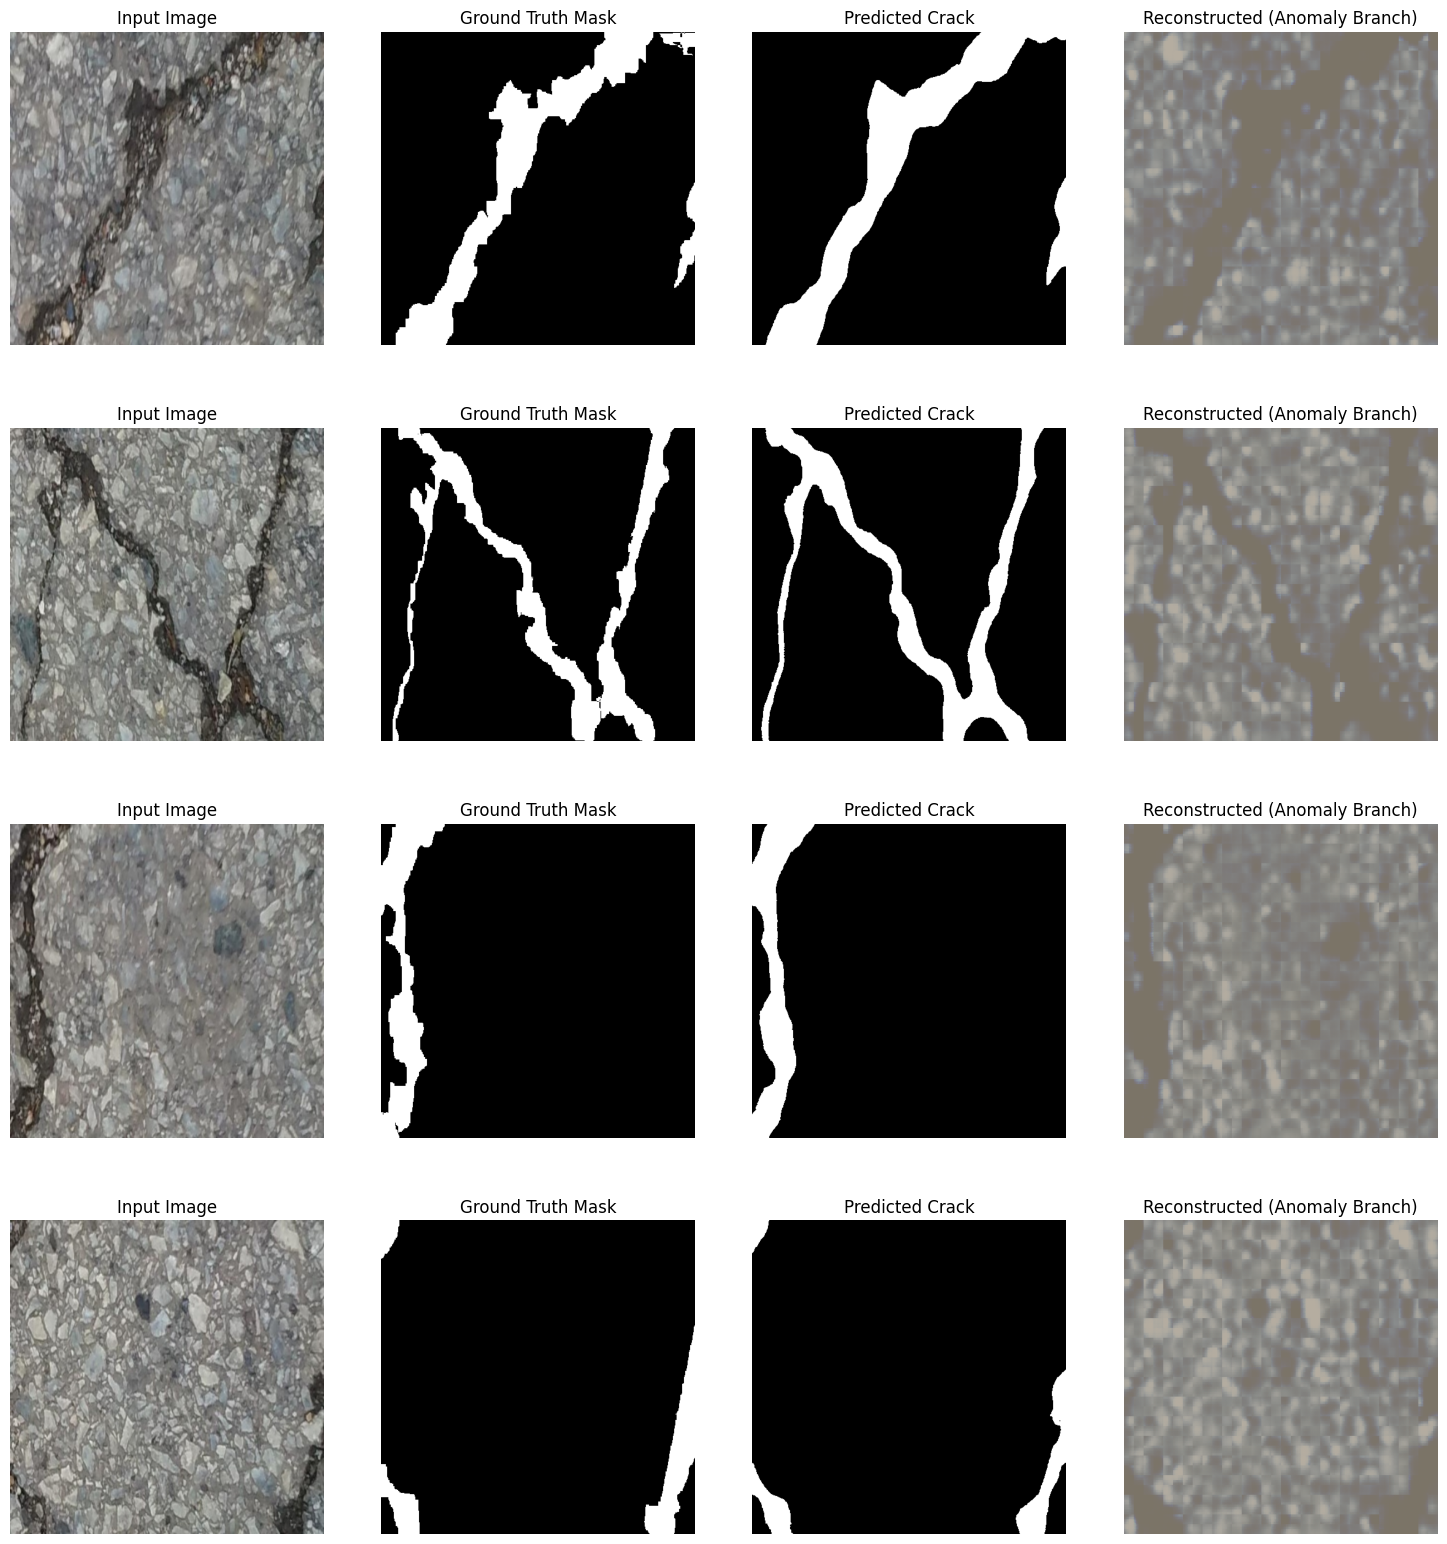

In [ ]:
if __name__ == "__main__":
    DATA_PATH = '/content/drive/MyDrive/CV Project/last_submission/Crack500'
    test_ds = RoadDataset(DATA_PATH, split="test", transform=get_transforms("val"))
    test_loader = DataLoader(test_ds, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=2)
    if 'trained_model' in locals():
        evaluate_detailed(trained_model, test_loader, CONFIG["device"])
        visualize_tests(trained_model, test_loader, CONFIG["device"])
    elif os.path.exists("road_damage_hybridnet_latest.pth"):
        device = CONFIG["device"]
        model = RoadDamageHybridNet(n_classes=1).to(device)
        model.load_state_dict(torch.load("road_damage_hybridnet_latest.pth", map_location=device))
        evaluate_detailed(model, test_loader, device)
        visualize_tests(model, test_loader, device)

## Roads-AD

In [ ]:
class SingleCountryDataset(Dataset):
    def __init__(self, root_dir, country_name, split="test", transform=None):
        self.transform = transform
        self.image_paths = []
        self.mask_paths = []

        # Specific path for one country
        img_dir = os.path.join(root_dir, split, "images", country_name)
        mask_dir = os.path.join(root_dir, split, "masks", country_name)

        if os.path.exists(img_dir):
            files = sorted(os.listdir(img_dir))
            for f in files:
                if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(img_dir, f)
                    # Split filename and extension (e.g., "road01.png" -> "road01", ".png")
                    file_name, ext = os.path.splitext(f)
                    # Construct mask filename (e.g., "road01_mask.png")
                    mask_f = f"{file_name}_mask{ext}"
                    mask_path = os.path.join(mask_dir, mask_f)
                    # Only add if mask exists
                    if os.path.exists(mask_path):
                        self.image_paths.append(img_path)
                        self.mask_paths.append(mask_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        _, mask = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].long()

        return image, mask.unsqueeze(0).float()

In [ ]:
import pandas as pd

def evaluate_all_countries(trained_model):
    device = CONFIG["device"]
    ROADS_AD_PATH = '/content/drive/MyDrive/CV Project/last_submission/Roads-AD'

    # Load Model
    model = trained_model

    # Get list of countries
    test_img_root = os.path.join(ROADS_AD_PATH, "test", "images")
    if not os.path.exists(test_img_root):
        print(f"Path not found: {test_img_root}")
        return

    countries = sorted([d for d in os.listdir(test_img_root) if os.path.isdir(os.path.join(test_img_root, d))])

    all_results = []

    print(f"Found {len(countries)} sub-directories. Starting evaluation...\n")

    for country in countries:
        print(f"--- Evaluating: {country} ---")

        # Create dataset for just this country
        ds = SingleCountryDataset(ROADS_AD_PATH, country, split="test", transform=get_transforms("val"))

        if len(ds) == 0:
            print(f"No valid images found for {country}. Skipping.")
            continue

        loader = DataLoader(ds, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=2)

        # Reuse your existing evaluate_detailed function
        # Note: We suppress the full print output inside evaluate_detailed to keep it clean
        # and just use the returned dictionary.
        metrics = evaluate_detailed(model, loader, device)

        # Add country name to metrics
        #visualize_tests(model, loader, device, country)
        metrics["Country"] = country
        all_results.append(metrics)
        print("\n")

    # 3. Summary Table
    if all_results:
        df = pd.DataFrame(all_results)
        # Reorder columns
        cols = ["Country", "dice", "iou", "precision", "recall", "accuracy"]
        df = df[cols]
        print("\n==========================================")
        print("       Roads-AD Per-Country Results       ")
        print("==========================================")
        print(df.to_string(index=False, float_format="%.4f"))
        return df

# Execute
if __name__ == "__main__":
    if os.path.exists('/content/drive/MyDrive'):
        if 'trained_model' in locals():
            results_df = evaluate_all_countries(trained_model)

Found 7 sub-directories. Starting evaluation...

--- Evaluating: anomaly_china_drone ---
Starting detailed evaluation on Validation Set...


Evaluating: 100%|██████████| 16/16 [00:02<00:00,  7.08it/s]



Validation Set Performance
Dice Coeff (F1): 0.1158
IoU:             0.0614
Precision:       0.6168
Recall:          0.0639
Accuracy:        0.9054


--- Evaluating: anomaly_china_motorbike ---
Starting detailed evaluation on Validation Set...


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  6.91it/s]



Validation Set Performance
Dice Coeff (F1): 0.0853
IoU:             0.0445
Precision:       0.3735
Recall:          0.0481
Accuracy:        0.9576


--- Evaluating: anomaly_czech ---
Starting detailed evaluation on Validation Set...


Evaluating: 100%|██████████| 3/3 [00:00<00:00,  5.58it/s]



Validation Set Performance
Dice Coeff (F1): 0.0667
IoU:             0.0345
Precision:       0.0447
Recall:          0.1314
Accuracy:        0.9503


--- Evaluating: anomaly_india ---
Starting detailed evaluation on Validation Set...


Evaluating: 100%|██████████| 10/10 [00:01<00:00,  7.24it/s]



Validation Set Performance
Dice Coeff (F1): 0.0158
IoU:             0.0080
Precision:       0.0226
Recall:          0.0122
Accuracy:        0.9364


--- Evaluating: anomaly_japan ---
Starting detailed evaluation on Validation Set...


Evaluating: 100%|██████████| 14/14 [00:02<00:00,  6.95it/s]



Validation Set Performance
Dice Coeff (F1): 0.0973
IoU:             0.0511
Precision:       0.0895
Recall:          0.1066
Accuracy:        0.9285


--- Evaluating: anomaly_norway ---
Starting detailed evaluation on Validation Set...


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.51it/s]



Validation Set Performance
Dice Coeff (F1): 0.0555
IoU:             0.0286
Precision:       0.0496
Recall:          0.0631
Accuracy:        0.9629


--- Evaluating: anomaly_united_states ---
Starting detailed evaluation on Validation Set...


Evaluating: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


Validation Set Performance
Dice Coeff (F1): 0.0039
IoU:             0.0019
Precision:       0.0044
Recall:          0.0035
Accuracy:        0.9286



       Roads-AD Per-Country Results       
                Country   dice    iou  precision  recall  accuracy
    anomaly_china_drone 0.1158 0.0614     0.6168  0.0639    0.9054
anomaly_china_motorbike 0.0853 0.0445     0.3735  0.0481    0.9576
          anomaly_czech 0.0667 0.0345     0.0447  0.1314    0.9503
          anomaly_india 0.0158 0.0080     0.0226  0.0122    0.9364
          anomaly_japan 0.0973 0.0511     0.0895  0.1066    0.9285
         anomaly_norway 0.0555 0.0286     0.0496  0.0631    0.9629
  anomaly_united_states 0.0039 0.0019     0.0044  0.0035    0.9286
